In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Retrieve data

We begin by fetching the reduced data using the Python script `data_transfer.py` from the file `df_merged.parquet`, then importing it into Pandas data frame.

In [2]:
df = pd.read_parquet('../scripts/df_merged.parquet', engine='pyarrow')

In [7]:
df.head(2)

,objectId,candid,jd,mjd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux,source
0,ZTF17aaaeclk,1356301332615015001,2.459111e+06,59080,1,0.000286,0.000027,0.000286,0.000004,1
1,ZTF17aaaeclk,1356301332615015001,2.459111e+06,59080,2,0.000636,0.000062,0.000636,0.000012,1


In [8]:
df.shape

(1900648, 10)

Here we extract all unique IDs from our data frame:

In [9]:
unique_ids = df['objectId'].unique().tolist()
len(unique_ids)

31881

#

To calculate the weight values \(w_i\), we use the formula: `w_i` =\begin{cases}
\frac{1}{{\sigma_i^2}}, & \text{if data is available for day } i \\
0, & \text{otherwise}
\end{cases}

In [10]:
missing_data = (df['source'] == 0) | (df['dc_sigflux'] == 0)
df['dc_weight'] = np.where(missing_data, 0, 1 / (df['dc_sigflux'] ** 2))
df['nr_weight'] = np.where(missing_data, 0, 1 / (df['nr_sigflux'] ** 2))

In [11]:
df[['source','dc_weight']].head(3)

,source,dc_weight
0,1,1.353949e+09
1,1,2.615609e+08
2,0,0.000000e+00


# 

# 

# With distance - factor test 

We group the data by shared ID and create `NumPy` arrays for flux, weighted flux, and the source test(if it's a missing day(data)). We also determine the length of each time series.

In [12]:
grouped = df.groupby('objectId')

F = grouped['dc_flux'].apply(lambda x: x.values)#.values
sig = grouped['dc_sigflux'].apply(lambda x: x.values)#.values
W = grouped['dc_weight'].apply(lambda x: x.values)#.values
source = grouped['source'].apply(lambda x: x.values)#.values
lengths = grouped['source'].apply(lambda x: len(x))#.values


# We are not working with this right now because it causes a problem (
# the arrangement of values in these arrays might not be aligned perfectly with our expectations,
# especially if the grouping operation resulted in different lengths of arrays for different groups)

We define the length of our query,window or chunk, along with the limit factor and the size of each window or chunk.

In [13]:
m=1
factor = 2*m+1 + 3*np.sqrt(2*(2*m+1))
chunk_size = 2 * (m + 1)

The `'no_match_test'` function evaluates whether there are any matches in the provided array, which contains the source test values for a window. If the sum of the array is less than or equal to 1, indicating that all values are missing or only one value is present, the function returns -99. Otherwise, it returns -1 to initialize the window's status as 'no match'.

In [14]:
def no_match_test(array):
    if array.sum() <= 1 : 
        return -99 ## all are missing, or only one is
    return -1 # initialise as no match  # can be modifieted ? 

"`objects`" list contains a subset of the objects we intend to work with.

"`L_max`" is defined to facilitate partial iteration, serving as a debugging aid by allowing a limit to be set on the number of iterations performed.

We initialize the NumPy arrays with `None` values.

In [64]:
objects = unique_ids[0:100]
num_objects = len(objects)
L_max = int(num_objects/2)
# L_max = 5
print("L_max ", L_max)

# T = np.empty(num_objects, dtype=object)
# F = np.empty(num_objects, dtype=object)
# W = np.empty(num_objects, dtype=object)
# sig = np.empty(num_objects, dtype=object) ### we will remove it ! 
# source = np.empty(num_objects, dtype=object)
# lengths= np.empty(num_objects, dtype=object)

R = np.empty(num_objects, dtype=object)
R_l = np.empty((num_objects, L_max), dtype=object)
alp = np.empty((num_objects, L_max), dtype=object)
d = np.empty((num_objects, L_max), dtype=object)

L_max  50


In [65]:
indexes_objects = range(num_objects)
Q = [None] * (L_max)

We initialize R using the '`no_match_test`' function.

In [66]:
for k in indexes_objects:
    
    n = lengths[objects[k]]
    num_chunks = int(n // 2)-m 

    #print(n,num_chunks)

    chunks = np.array([source[objects[k]][i*2 : (i*2+chunk_size)] for i in range(num_chunks)])
    result = np.array(list(map(no_match_test, chunks)))
    R[k] = result.copy()
    
    
    for l in range(L_max):
        R_l[k][l] = result.copy()
    # a for loop isn't a good idea !!!! 
    


### Loop to compute the distance of the subsequence in the time series to its nearest neighbor.

In [67]:
start_time = time.time()


l= 0
while (l < L_max):
    indexes_array = np.array([np.where(array == -1)[0] for array in R], dtype=object)
    
    has_non_empty_list = np.any([value.size > 0 for value in indexes_array])
    if not has_non_empty_list:
        print("break , l = ", l )
        break
        
    for k in range(len(R)): # we can remove the loop for here ! ???
          if indexes_array[k].size != 0:
            f = F[objects[k]]
            
            index_no_match = indexes_array[k][0]

            #print(index_no_match, R[k])
            k_Query_taked = k 
            
            Q[l] = f[index_no_match*2 : index_no_match*2 +chunk_size]
            break

    for k in range(len(objects)):
        f = F[objects[k]]
        w = W[objects[k]]
        n = lengths[objects[k]]
        n_c = n - 2*m # (number of chunks x 2) ! it's (n/2 - m) but to optimize we mutiply by 2 directly !  
        #print(n, n_c,len(R[k]))



        s_1 = np.zeros(n_c, dtype=float)
        s_2 = np.zeros(n_c, dtype=float)
        
        for j in range(0,m+1): 
            h = np.tile(Q[l][j*2: j*2+2], (len(f[j*2:j*2+ n_c]) // 2, 1)).ravel() # array of h for r and g successive for the vectorisation

            s_1[:] += (f[j*2:j*2+ n_c]*h*w[j*2:j*2+ n_c])
            s_2[:] += (h**2 * w[j*2:j*2+ n_c])


        s_n = s_1[::2] + s_1[1::2]  
        s_d = s_2[::2] + s_2[1::2] 
        
        mask_no_0 = (s_d != 0)
        alp[k][l] = np.zeros_like(s_d, dtype=float)

        alp[k][l][mask_no_0] = s_n[mask_no_0] / s_d[mask_no_0] # # Perform division only where s_d(i) is not zero

        alpha = np.repeat(alp[k][l], 2) # duplicate alpha for each value (one for r and second for g)
     
    
        dd = np.zeros(n_c, dtype=float)
        
        for j in range(0,m+1):
            h = np.tile(Q[l][j*2: j*2+2], (len(f[j*2:j*2+ n_c]) // 2, 1)).ravel() # array of h for r and g successive for the vectorisation
            
            dd[:] += ((f[j*2:j*2+ n_c] - alpha[:] * h)**2) * w[j*2:j*2+ n_c] 
            #alpha[:n-j*2] ==> alpha[:]

        d[k][l] = dd[::2] + dd[1::2]
        
        factor_comparison =  d[k][l] <= factor
                
        R[k][indexes_array[k][factor_comparison[indexes_array[k]]]] = l # explanation follows below!

#         print("indexes_array",indexes_array[k])
#         print("factor_comparison",factor_comparison)
#         print("factor_comparison[indexes_array]",factor_comparison[indexes_array[k]])
#         print("indexes_array[factor_comparison[indexes_array]]",indexes_array[k][factor_comparison[indexes_array[k]]])
#         print("R[k]",R[k])
#         print("indexes_array[factor_comparison[indexes_array]]",R[k][indexes_array[k][factor_comparison[indexes_array[k]]]])
#         print()
#         print()
        for i in range(len(factor_comparison)):
            if factor_comparison[i] and R_l[k][l][i] != -99:# and i != index_no_match: it isn't bad but It may 
                R_l[k][l][i] = l
                
        """for i in indexes_array[k]:
            #print(i)
            if d[k][l][i] <= factor : 
                R[k][i] = l"""
                
    R_l[k_Query_taked][l][index_no_match] = -2
#     R[k_Query_taked][index_no_match] = -2

    
     
    #print("l = ",l)
 
    l += 1 
    
print("l = ",l)



end_time = time.time()

# Compute the elapsed time
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")

l =  50
Elapsed time: 0.4213228225708008 seconds


Let's break down the expression `R[k][indexes_array[k][factor_comparison[indexes_array[k]]]] = l` step by step:

1. `indexes_array[k]`: This selects the array of indexes corresponding to the k-th element of `indexes_array`.
2. `factor_comparison[indexes_array[k]]`: This applies boolean indexing to `factor_comparison` using the indexes from `indexes_array[k]`. It selects only the elements of `factor_comparison` corresponding to the indexes in `indexes_array[k]`.
3. `indexes_array[k][factor_comparison[indexes_array[k]]]`: This gives the indices where the condition `factor_comparison` is true for the k-th element of `indexes_array`.
4. `R[k][indexes_array[k][factor_comparison[indexes_array[k]]]]`: This uses the indices obtained in the previous step to select elements from the k-th row of `R`.
5. `= l`: Finally, it assigns the value `l` to the selected elements of `R[k]`.


In [ ]:
np.savez('nested_arrays.npz', array1=d, array2=R, array3=Q)

# Load the arrays from the .npz file
data = np.load('nested_arrays.npz', allow_pickle=True)

# Retrieve the arrays from the loaded data
# d1 = data['array1']
# R1 = data['array2']
# Q1 = data['array3']

#

#

## Functions to compute the numbers of matches and plot the results 

In [20]:
#matches = number_matches(R_l[k])
def number_matches(R_l_k):
    # Get the length of the first sub-array
    length = len(R_l_k[0])

    # Initialize the list to store the number of matches for each index
    matches = [0] * length

    # Iterate through each sub-array
    for sub_array in R_l_k:
        # Iterate through each element and count matches for each index
        for i, elem in enumerate(sub_array):
            if elem >= 0:
                matches[i] += 1

    return matches

In [21]:
def number_matches_for_all_k(R_l):
    all_matches = []  # Initialize a list to store matches for all values of k

    # Iterate through each R_l[k]
    for R_l_k in R_l:
        # Get the length of the first sub-array
        length = len(R_l_k[0])

        # Initialize the list to store the number of matches for each index
        matches = [0] * length

        # Iterate through each sub-array
        for sub_array in R_l_k:
            # Iterate through each element and count matches for each index
            for i, elem in enumerate(sub_array):
                if elem >= 0:
                    matches[i] += 1

        all_matches.append(matches)  # Store matches for current k

    return all_matches


# all_matches will be a list where each element is matches for each k
all_matches = number_matches_for_all_k(R_l)


In [22]:
def lowest_values(all_matches):
    lowest_values = []  # Initialize a list to store the lowest 10 values

    # Iterate through each list of matches for each k
    for k, matches_k in enumerate(all_matches):
        # Iterate through each match count and index i
        for i, match_count in enumerate(matches_k):
            if R[k][i] !=-99:
                lowest_values.append((match_count, k, i))  # Store match count, k, and i

    # Sort the lowest values based on match count
    lowest_values.sort(key=lambda x: x[0])

    return lowest_values

# lowest_ will be a list of tuples where each tuple contains (match_count, k, i)
lowest = lowest_values(all_matches)
lowest

[(0, 0, 5),
 (0, 0, 18),
 (0, 1, 3),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 10),
 (0, 1, 13),
 (0, 1, 14),
 (0, 3, 15),
 (0, 4, 3),
 (0, 4, 4),
 (0, 4, 8),
 (0, 5, 23),
 (0, 6, 23),
 (0, 7, 0),
 (0, 7, 1),
 (0, 7, 7),
 (0, 7, 16),
 (0, 8, 7),
 (0, 8, 15),
 (0, 9, 8),
 (0, 9, 28),
 (0, 9, 29),
 (0, 10, 17),
 (0, 10, 18),
 (0, 10, 25),
 (0, 11, 0),
 (0, 11, 27),
 (0, 14, 16),
 (0, 14, 17),
 (0, 14, 19),
 (0, 14, 20),
 (0, 15, 8),
 (0, 15, 9),
 (0, 15, 29),
 (0, 17, 3),
 (0, 19, 7),
 (0, 22, 27),
 (0, 24, 4),
 (0, 24, 5),
 (0, 25, 2),
 (0, 25, 3),
 (0, 25, 7),
 (0, 25, 10),
 (0, 25, 15),
 (0, 26, 0),
 (0, 27, 7),
 (0, 30, 16),
 (0, 31, 28),
 (0, 34, 17),
 (0, 34, 25),
 (0, 34, 28),
 (0, 35, 17),
 (0, 35, 25),
 (0, 35, 28),
 (0, 36, 4),
 (0, 36, 5),
 (0, 36, 11),
 (0, 36, 12),
 (0, 37, 5),
 (0, 37, 12),
 (0, 38, 0),
 (0, 38, 1),
 (0, 38, 7),
 (0, 38, 8),
 (0, 38, 12),
 (0, 38, 25),
 (0, 38, 26),
 (0, 38, 28),
 (0, 38, 29),
 (0, 41, 7),
 (0, 41, 11),
 (0, 41, 16),
 (0, 41, 18),
 (0, 42, 8),
 (0, 4

In [23]:
def plot_distance_flux(k,l):
    
    plt.figure(figsize=(14, 12))

    # Plot for F[k]
    plt.subplot(2, 1, 1)

    for i in range(int(len(F[objects[k]])/2)):
        if source[objects[k]][2*i] == 0:
            marker = 'x'
            plt.errorbar(i, F[objects[k]][2*i], 
                     #sig[objects[k]][2*i]*0.4,
                     c='C0', marker=marker)
        else:
            marker = 'o'
            plt.errorbar(i, F[objects[k]][2*i], 
                     sig[objects[k]][2*i],
                     c='C0', marker=marker)

        if source[objects[k]][2*i+1] == 0:
            marker = 'x'
            plt.errorbar(i, F[objects[k]][2*i+1],
                     #sig[objects[k]][2*i+1]*0.4,
                     c='C1', marker=marker)
            
        else:
            marker = 'o'
            plt.errorbar(i, F[objects[k]][2*i+1],
                     sig[objects[k]][2*i+1],
                     c='C1', marker=marker)
        
    plt.plot([], [], color='C1', marker='x', label='missing points !')
    plt.plot([], [], color='C0', marker='o', label='origin')
    plt.plot([], [], color='C0', marker='x', label='missing points !')
    plt.plot([], [], color='C1', marker='o', label='origin')

    plt.plot(range(int(len(F[objects[k]])/2)), F[objects[k]][::2], c='C0', linewidth = 1)
    plt.plot(range(int(len(F[objects[k]])/2)), F[objects[k]][1::2], c='C1', linewidth = 1)

    plt.plot(range(int(len(Q[l])/2)), Q[l][::2], c='g', label='Q[l]',marker='.', linewidth=3, zorder=3)
    plt.plot(range(int(len(Q[l])/2)), Q[l][1::2], c='r', label='Q[l]',marker='.', linewidth=3, zorder=3)

    # Define the window of indices
    window_start = 0  # Index of the window start
    window_end = int(len(Q[l])/2 - 1)  # Index of the window end

    # Create an array of float indices
    indices = np.arange(window_start, window_end + 1)
    indices = np.concatenate(([indices[0] - 0.5], indices, [indices[-1] + 0.5]))

    # Plot a shaded region for the window
    plt.fill_between(indices, min(Q[l])/1.2, max(Q[l])*1.2, color='gray', alpha=0.2)

    # plt.xlabel('Index')
    plt.ylabel('Flux')
    # plt.title('Flux Plot')
    plt.legend()




    ###############                       Plot for d[k][0]                       ###############

    plt.subplot(2, 1, 2)
    plt.plot(range(len(d[k][l])), d[k][l],color='C0', linestyle='-',linewidth=1)
    matches = all_matches[k]
    for i, match_count in enumerate(matches):
        plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(match_count), fontsize=10, color='red', ha='left')


    # Plot dummy points with desired colors and markers
    plt.plot([], [], color='black', marker='o', label='Query chosed')
    plt.plot([], [], color='red', marker='x', label='missing cases !')
    plt.plot([], [], color='blue', marker='s', label='Matched here')
    plt.plot([], [], color='green', marker='*', label='Matches with a different `l` (Query)')
    plt.plot([], [], color='yellow', marker='^', label=f'Not matched with any of the {L_max} options we selected')

    for i, val in enumerate(R_l[k][l]):
        if val == -99:
            plt.scatter(i, d[k][l][i], color='red', marker='x', s=50)  # marker size 50
        elif val == l:
            plt.scatter(i, d[k][l][i], color='blue', marker='s', s=50)
        elif val == -2:
            plt.scatter(i, d[k][l][i], color='black', marker='o', s=50)  
        #elif (val == -1) and (R[k][i] == -1 or R[k][i] == -2):
        elif matches[i]==0:
            plt.scatter(i, d[k][l][i], color='yellow', marker='^', s=50)  
        else:
            plt.scatter(i, d[k][l][i], color='green', marker='*', s=75)
            
            


    plt.legend(fontsize=8) 
    #plt.legend(loc='upper right', fontsize=8)

    plt.ylabel('distance')



    ###############                       Plot for alpha[k][l]                       ###############

#     plt.subplot(3, 1, 3)
#     plt.plot(range(len(alp[k][l])), alp[k][l], marker='.', linestyle='-',color='black')
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     # plt.title('alpha Plot')




    plt.subplots_adjust(top=0.93)  # Adjust the top margin for the super title
    plt.suptitle(f"{objects[k]}, k = {k}, l = {l} ", fontname='Arial', fontsize=16, fontweight='bold')
    #plt.tight_layout()
    plt.show()



# plot by multiple l

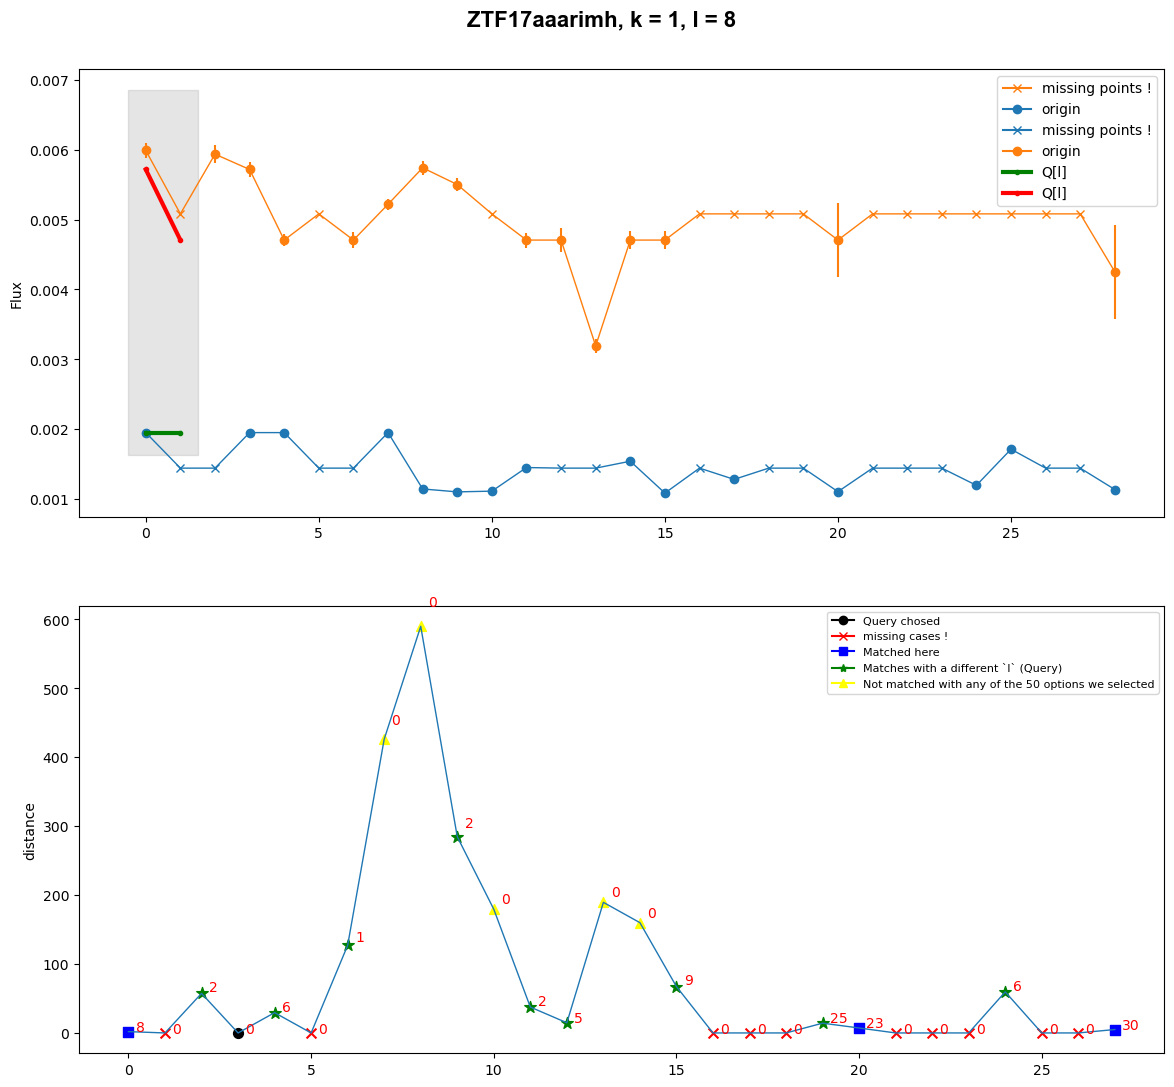

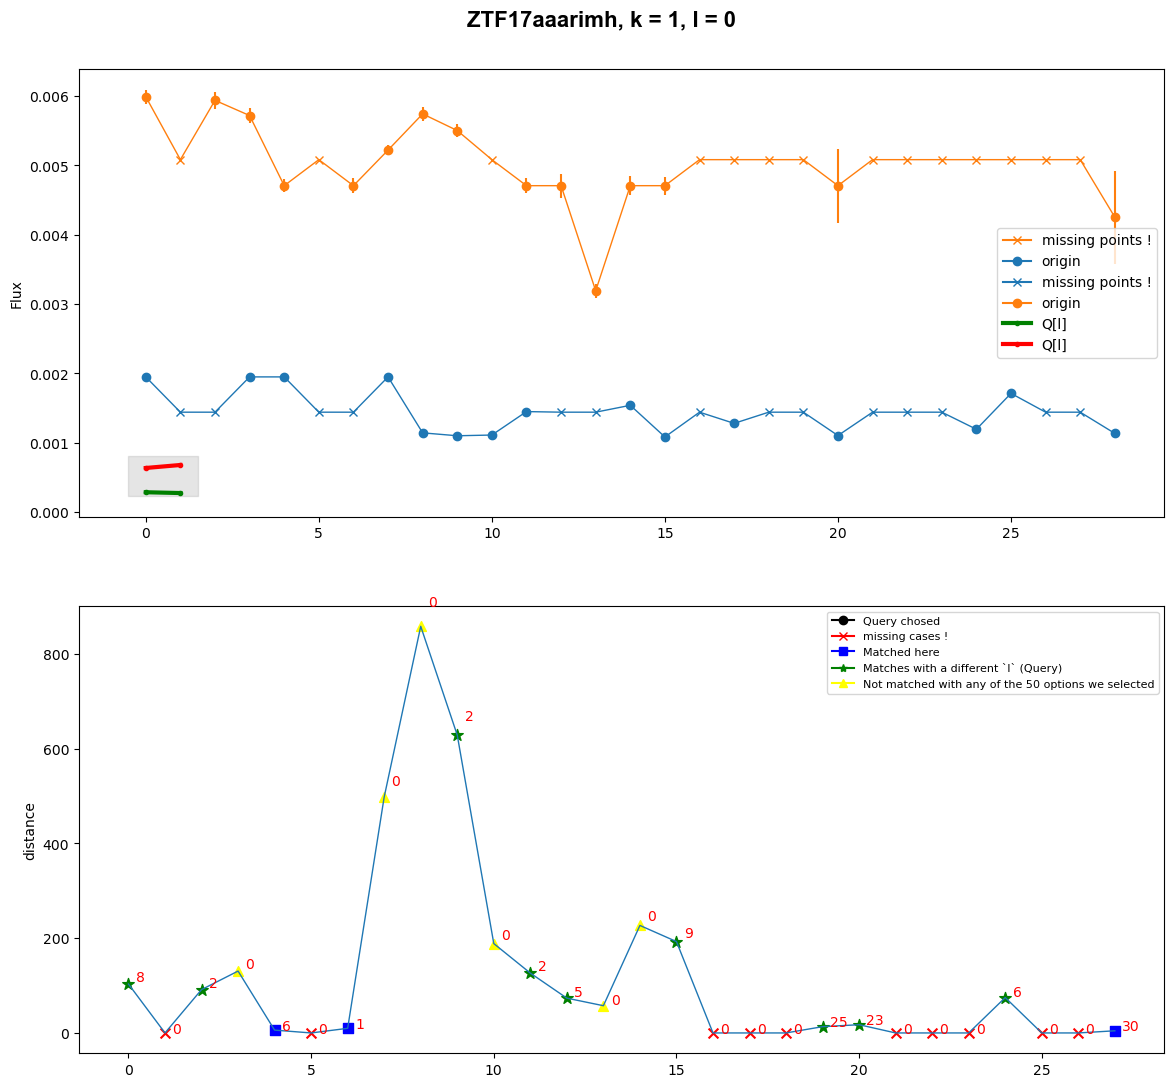

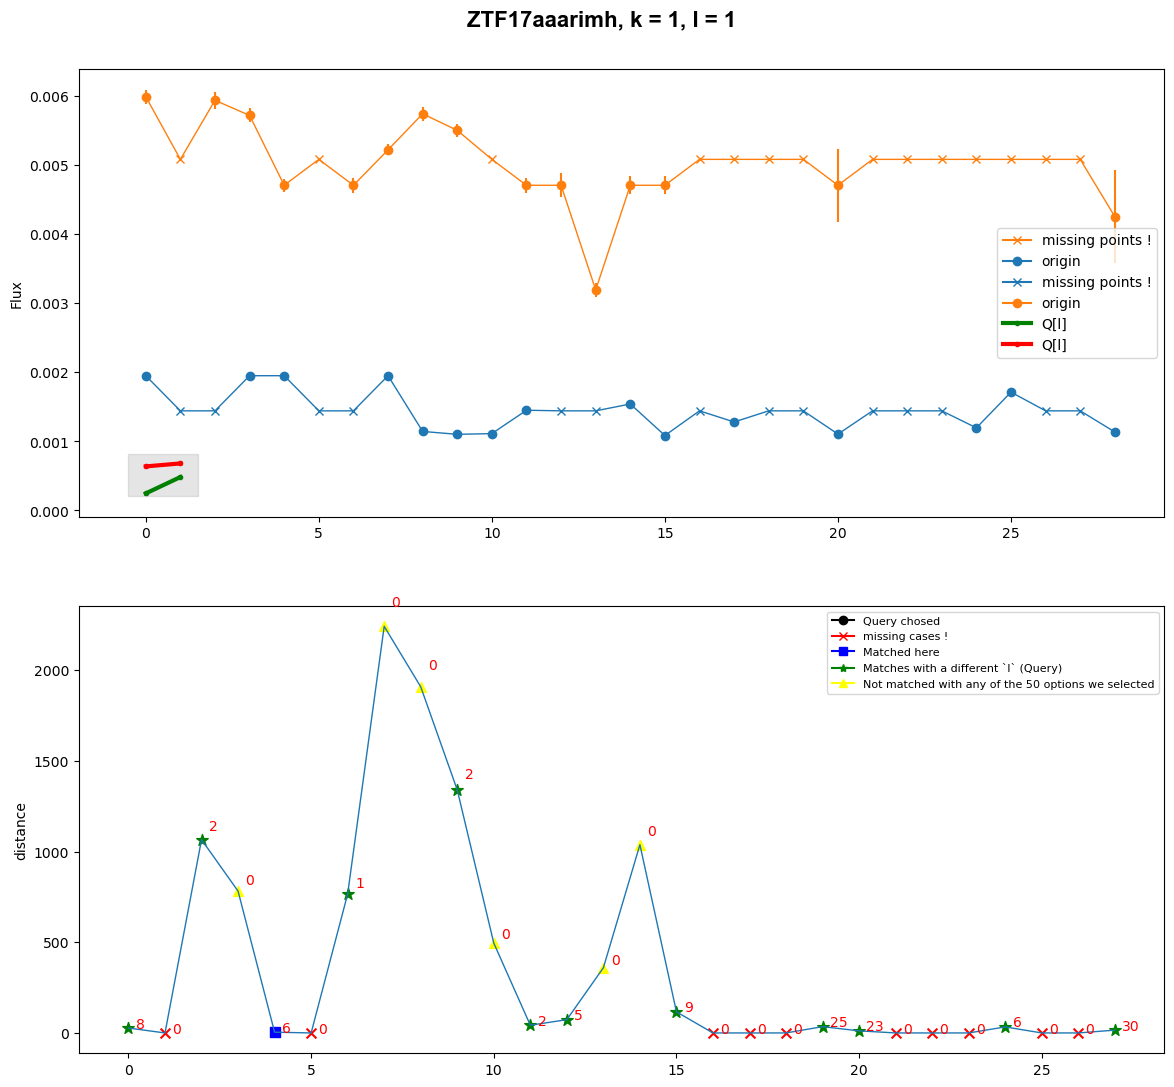

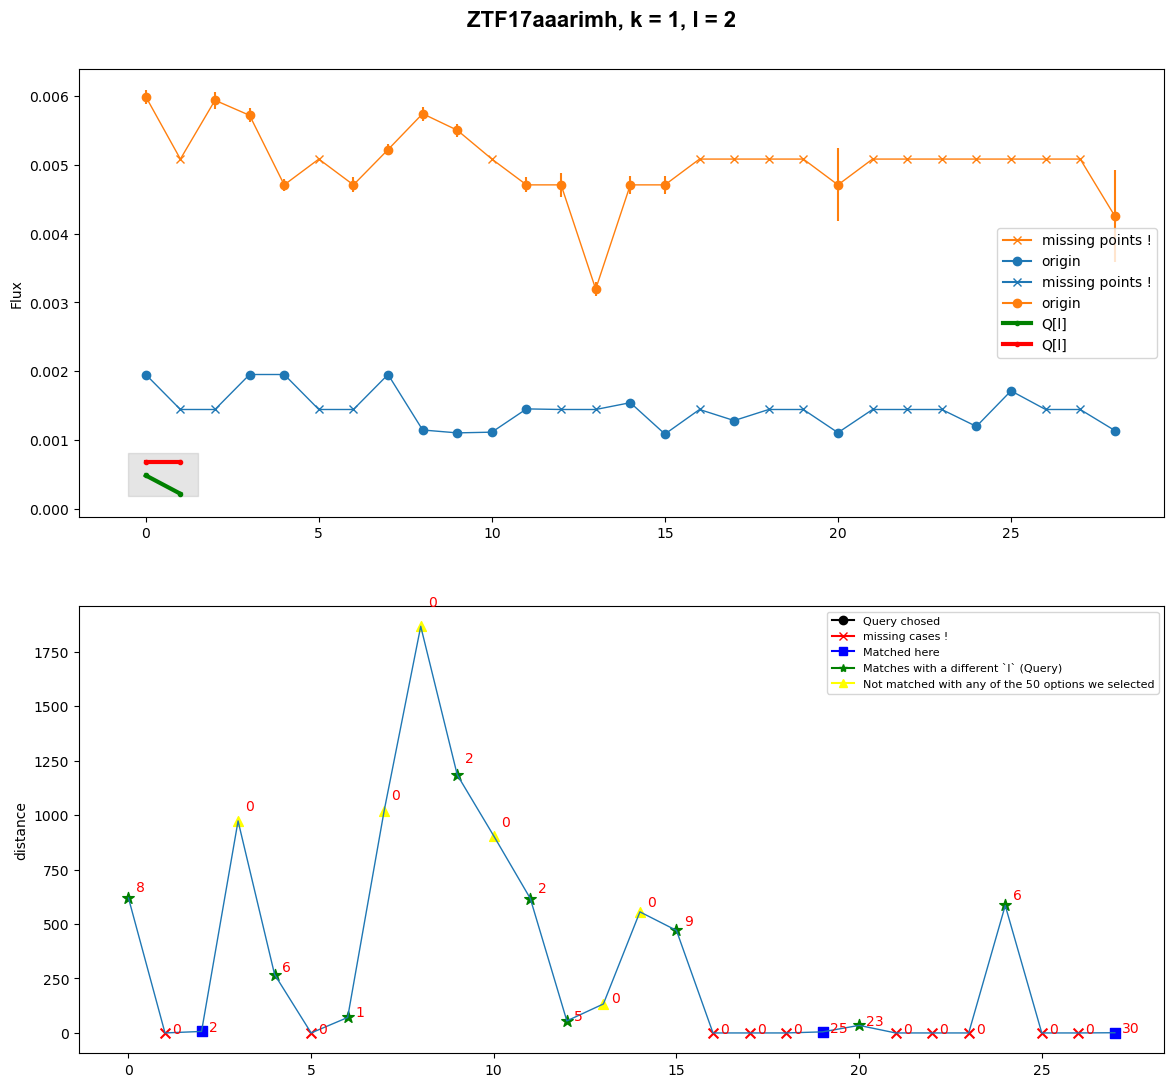

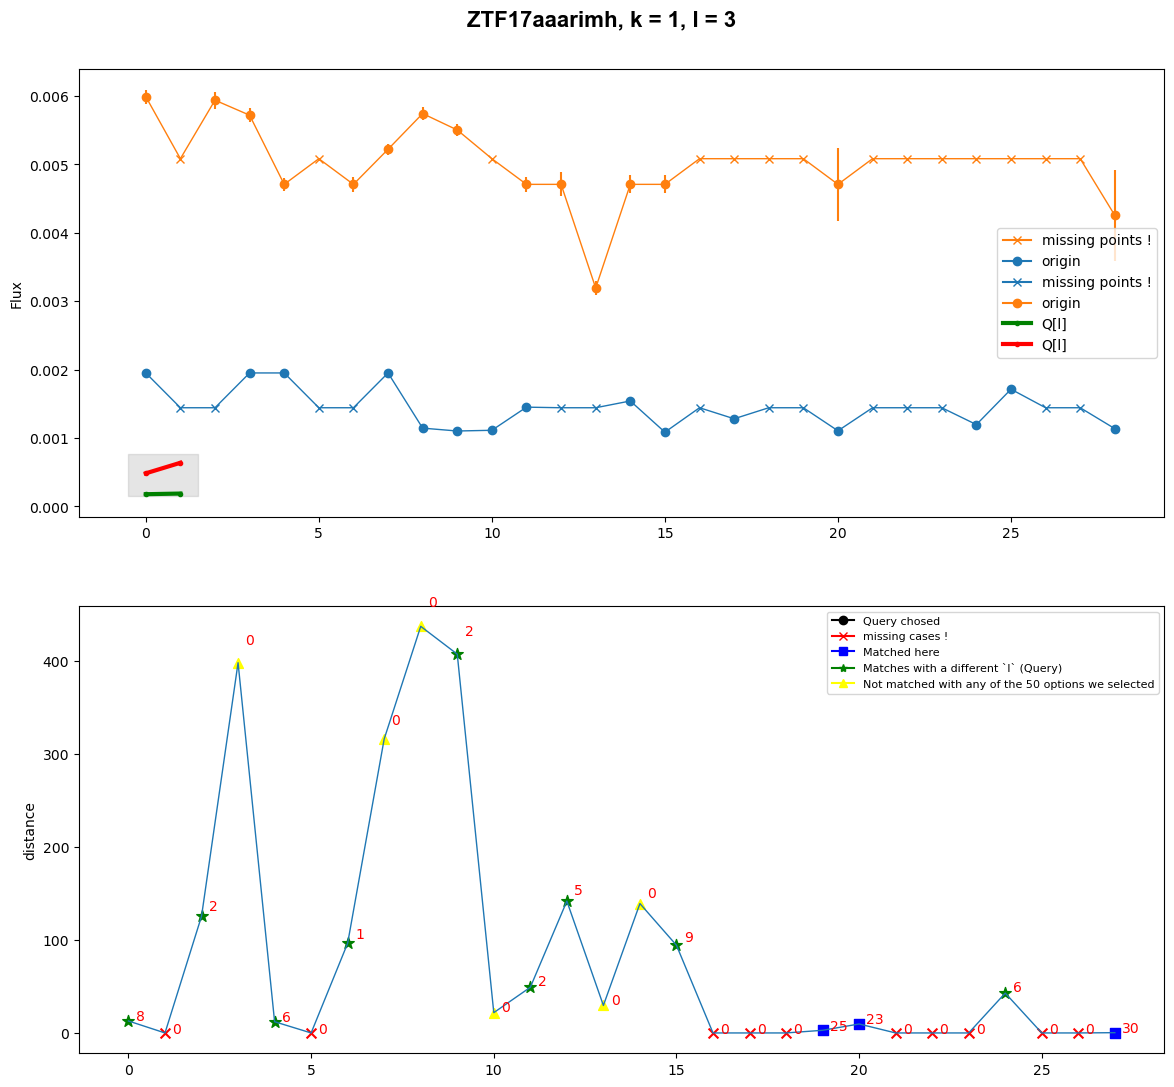

In [24]:
l_values = [8,0,1,2,3]#range(L_max)  # Replace num_values_of_l with the actual number of l values
k=1
for l in l_values:
    
    plot_distance_flux(k,l)


#

# Distinguishing the two cases!

In [25]:
m=1 # here the minimin is 1 !! 
factor = 2*m+1 + 3*np.sqrt(2*(2*m+1))
chunk_size = 2 * (m + 1)

In [26]:
# def no_match_test_s(array):
#     global m
#     if array.sum() <= 1 :
#         if m == 0 and array.sum() == 0:
#             return -99 ## all are missing, or all except one are
#         elif m != 0:
#             return -99
#     return -1 # initialise as no match  # can be modifieted ? 



In [55]:
objects = unique_ids[0:10]
num_objects = len(objects)
L_max = int(num_objects/2)

print("L_max ", L_max)

R_r = np.empty(num_objects, dtype=object)
R_g = np.empty(num_objects, dtype=object)

R_l_r = np.empty((num_objects, L_max), dtype=object)
R_l_g = np.empty((num_objects, L_max), dtype=object)

alp = np.empty((num_objects, L_max), dtype=object)
d_r = np.empty((num_objects, L_max), dtype=object)
d_g = np.empty((num_objects, L_max), dtype=object)

L_max  5


In [56]:
indexes_objects = range(num_objects)
Q = [None] * (L_max)

In [57]:
for k in indexes_objects:

    n = lengths[objects[k]]
    num_chunks = int(n // 2)-m 
    
    chunks_g = np.array([source[objects[k]][i*2 : (i*2+chunk_size):2] for i in range(num_chunks)])
    chunks_r = np.array([source[objects[k]][1+i*2 : (i*2+chunk_size):2] for i in range(num_chunks)])
    result_r = np.array(list(map(no_match_test, chunks_r)))
    result_g = np.array(list(map(no_match_test, chunks_g)))
    
    R_r[k] = result_r.copy()
    R_g[k] = result_g.copy()
    
        
    for l in range(L_max):
        R_l_r[k][l] = result_r.copy()
        R_l_g[k][l] = result_g.copy()
    # a for loop isn't a good idea !!!! 
        

In [58]:
start_time = time.time()


l= 0
while (l < L_max):
    indexes_array_r = np.array([np.where(array == -1)[0] for array in R_r], dtype=object)
    indexes_array_g = np.array([np.where(array == -1)[0] for array in R_g], dtype=object)
#     break
    empty_lists = np.all([value.size == 0 for value in indexes_array_r]) or np.all([value.size == 0 for value in indexes_array_g])
    if empty_lists:
        print("break , l = ", l )
        break
        
    for k in range(len(R_g)): # we can remove the loop for here ! ???
          if (indexes_array_g[k].size != 0):
            f = F[objects[k]]
            
            k_Query_taked_g = k 

            index_no_match_g = indexes_array_g[k][0] # here x 2 because we have the indexes only for g (I need to check this point)        
            Q[l] = f[index_no_match_g* 2  : index_no_match_g* 2  +chunk_size:2]
            break
            
    for k in range(len(R_r)): # we can remove the loop for here ! ???
          if (indexes_array_r[k].size != 0):
            f = F[objects[k]]
            k_Query_taked_r = k 

            index_no_match_r = indexes_array_r[k][0]  #+1
            for i in range(1, chunk_size, 2):
                 Q[l] = np.insert(Q[l], i, f[index_no_match_r*2 + i : index_no_match_r*2 + i + 1])

            #Q[l] = f[index_no_match : index_no_match +chunk_size]
            break    
    
    
    
    for k in range(len(objects)):
        f = F[objects[k]]
        w = W[objects[k]]
        n = lengths[objects[k]]
        n_c = n - 2*m # (number of chunks x 2) ! it's (n/2 - m) but to optimize we mutiply by 2 directly !  
        #print(n, n_c,len(R[k]))



        s_1 = np.zeros(n_c, dtype=float)
        s_2 = np.zeros(n_c, dtype=float)
        
        for j in range(0,m+1): 
            h = np.tile(Q[l][j*2: j*2+2], (len(f[j*2:j*2+ n_c]) // 2, 1)).ravel() # array of h for r and g successive for the vectorisation

            s_1[:] += (f[j*2:j*2+ n_c]*h*w[j*2:j*2+ n_c])
            s_2[:] += (h**2 * w[j*2:j*2+ n_c])

        s_n = s_1#[::2] + s_1[1::2]  # this needs to optimizate with new variables ! 
        s_d = s_2#[::2] + s_2[1::2] 
        
        mask_no_0 = (s_d != 0)
        alp[k][l] = np.zeros_like(s_d, dtype=float)

        alp[k][l][mask_no_0] = s_n[mask_no_0] / s_d[mask_no_0] # # Perform division only where s_d(i) is not zero

        alpha = alp[k][l]#np.repeat(alp[k][l], 2) # duplicate alpha for each value (one for r and second for g)
     
    
        dd = np.zeros(n_c, dtype=float)
        
        for j in range(0,m+1):
            h = np.tile(Q[l][j*2: j*2+2], (len(f[j*2:j*2+ n_c]) // 2, 1)).ravel() # array of h for r and g successive for the vectorisation
            
            dd[:] += ((f[j*2:j*2+ n_c] - alpha[:] * h)**2) * w[j*2:j*2+ n_c] 
            #alpha[:n-j*2] ==> alpha[:]

        d_g[k][l] = dd[::2]
        d_r[k][l] = dd[1::2]
        
        """factor_comparison =  d_g[k][l] <= factor
        R_g[k][indexes_array_g[k][factor_comparison[indexes_array_g[k]]]] = l # explanation follows below!
                
        factor_comparison =  d_r[k][l] <= factor
        R_r[k][indexes_array_r[k][factor_comparison[indexes_array_r[k]]]] = l # explanation follows below!"""
        

        for i in indexes_array_g[k]:
            if d_g[k][l][i] <= factor : 
                R_g[k][i] = l
        for i in indexes_array_r[k]:
            if d_r[k][l][i] <= factor : 
                R_r[k][i] = l
                
        factor_comparison = d_r[k][l] <= factor      
        
        for i in range(len(factor_comparison)):
            if factor_comparison[i] and R_l_r[k][l][i] != -99: 
                R_l_r[k][l][i] = l
            
        factor_comparison = d_g[k][l] <= factor      

        for i in range(len(factor_comparison)):
            if factor_comparison[i] and R_l_g[k][l][i] != -99: 
                R_l_g[k][l][i] = l
                
        """for i in indexes_array[k]:
            #print(i)
            if d[k][l][i] <= factor : 
                R[k][i] = l"""
                
    R_l_r[k_Query_taked_r][l][index_no_match_r] = -2
    R_l_g[k_Query_taked_g][l][index_no_match_g] = -2

    
    l += 1 
    
print("l = ",l)



end_time = time.time()

# Compute the elapsed time
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")

l =  5
Elapsed time: 0.008867740631103516 seconds


#

In [59]:
all_matches_r = number_matches_for_all_k(R_l_r)
all_matches_g = number_matches_for_all_k(R_l_g)


In [60]:
k = 0
l = 1
unique_ids[k]

'ZTF17aaaeclk'

In [84]:
color = ['green','red']
color_Q = ['C0','C1']

def plot_distance_flux_r_g(k,l,j=0,d=d_g,R_l=R_l_g,matches=all_matches_g[k]): # default case : g (j=0 ==> green)
    
    # # Plotting
    plt.figure(figsize=(15, 10))

    # Plot for F[k]
    plt.subplot(2, 1, 1)

    for i in range(int(len(F[objects[k]])/2)):
        if source[objects[k]][2*i+j] == 0:
            marker = 'x'
            plt.errorbar(i, F[objects[k]][2*i+j], 
                     #sig[objects[k]][2*i+j]*0.4,
                     c=color[j], marker=marker)
        else:
            marker = 'o'
            plt.errorbar(i, F[objects[k]][2*i+j], 
                         sig[objects[k]][2*i+j],
                         c=color[j], marker=marker)


    plt.plot([], [], color=color[j], marker='o', label='origin')
    plt.plot([], [], color=color[j], marker='x', label='missing points !')


    plt.plot(range(int(len(F[objects[k]])/2)), F[objects[k]][j::2], c=color[j], linewidth = 1)


    plt.plot(range(int(len(Q[l])/2)), Q[l][j::2], c=color_Q[j], label='Q[l]',marker='.')

    # Define the window of indices
    window_start = -0  # Index of the window start
    window_end = int(len(Q[l])/2 - 1)  # Index of the window end

    # Create an array of float indices
    indices = np.arange(window_start, window_end + 1)
    indices = np.concatenate(([indices[0] - 0.5], indices, [indices[-1] + 0.5]))

    # Plot a shaded region for the window
    plt.fill_between(indices, min(Q[l][j::2])/1.2, max(Q[l][j::2])*1.2, color='gray', alpha=0.2)

    plt.ylabel('Flux')
    plt.legend()

    # Plot for d[k][0]

    plt.subplot(2, 1, 2)
    plt.plot(range(len(d[k][l])), d[k][l],color='C0', linestyle='-',linewidth=1)

        # Plot dummy points with desired colors and markers
    plt.plot([], [], color='black', marker='o', label='Query chosed')
    plt.plot([], [], color='red', marker='x', label='missing cases !')
    plt.plot([], [], color='blue', marker='s', label='Matched here')
    plt.plot([], [], color='green', marker='*', label='Matches with a different `l` (Query)')
    plt.plot([], [], color='yellow', marker='^', label=f'Not matched with any of the {L_max} options we selected')

    for i, val in enumerate(R_l[k][l]):
            if val == -99:
                plt.scatter(i, d[k][l][i], color='red', marker='x', s=50)  # marker size 50
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(matches[i]), fontsize=10, color='red', ha='left')

            elif val == l:
                plt.scatter(i, d[k][l][i], color='blue', marker='s', s=50)
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(matches[i]), fontsize=10, color='blue', ha='left')

            elif val == -2:
                plt.scatter(i, d[k][l][i], color='black', marker='o', s=50) 
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(matches[i]), fontsize=10, color='black', ha='left')
            elif matches[i]==0:
                plt.scatter(i, d[k][l][i], color='yellow', marker='^', s=50) 
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(matches[i]), fontsize=10, color='yellow', ha='left')

            else:
                plt.scatter(i, d[k][l][i], color='green', marker='*', s=75)
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(matches[i]), fontsize=10, color='green', ha='left')




    plt.legend(fontsize=8) 

    plt.ylabel('distance')


    # # Plot for alphat[k][0]
    # plt.subplot(4, 1, 4)
    # plt.plot(range(len(alp[k][l][::2])), alp[k][l][::2], marker='.', linestyle='-',color='black')
    # plt.xlabel('Index')
    # plt.ylabel('alpha')
    # # plt.title('alpha Plot')


    plt.subplots_adjust(top=0.93)  # Adjust the top margin for the super title
    plt.suptitle(f"{objects[k]}", fontname='Arial', fontsize=16, fontweight='bold')

    plt.show()



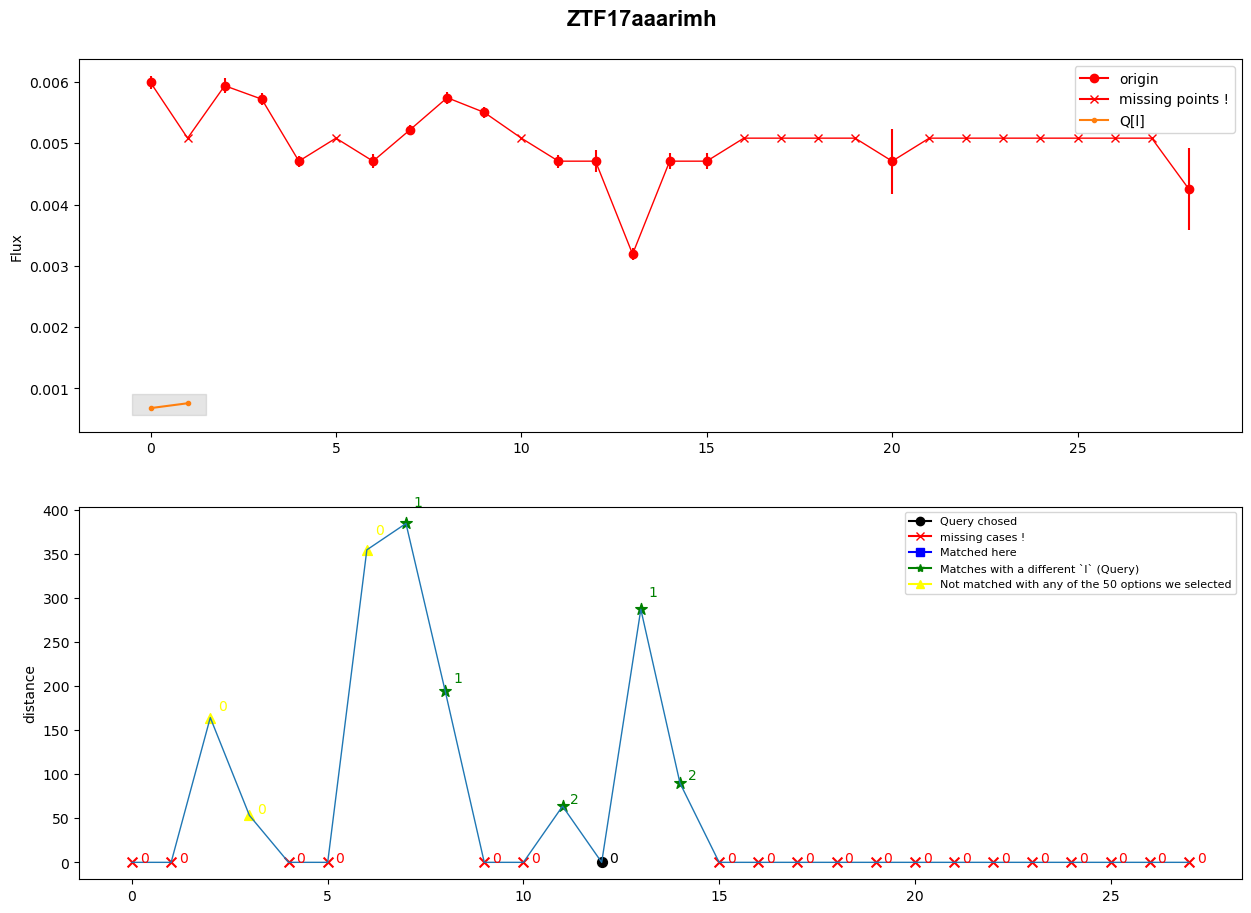

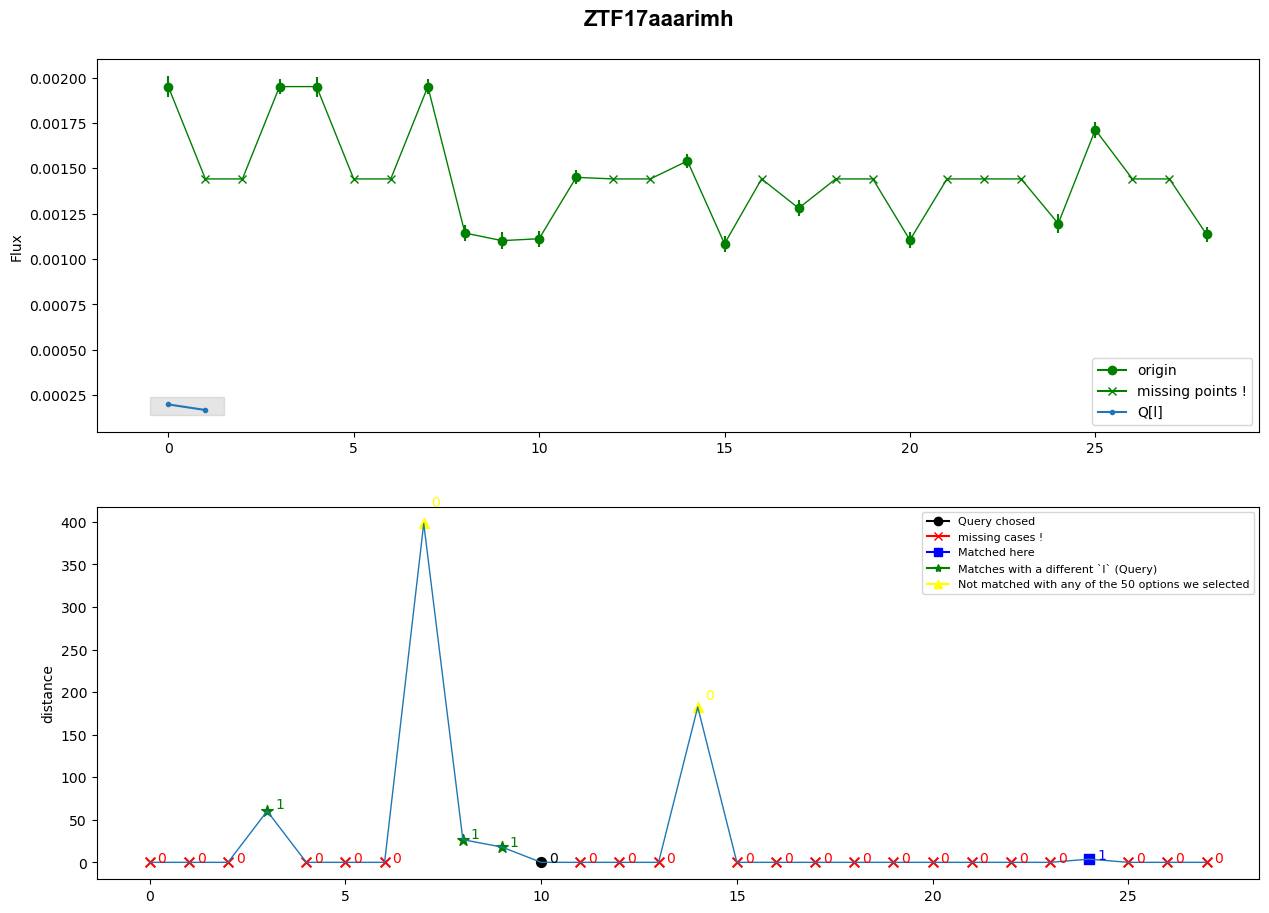

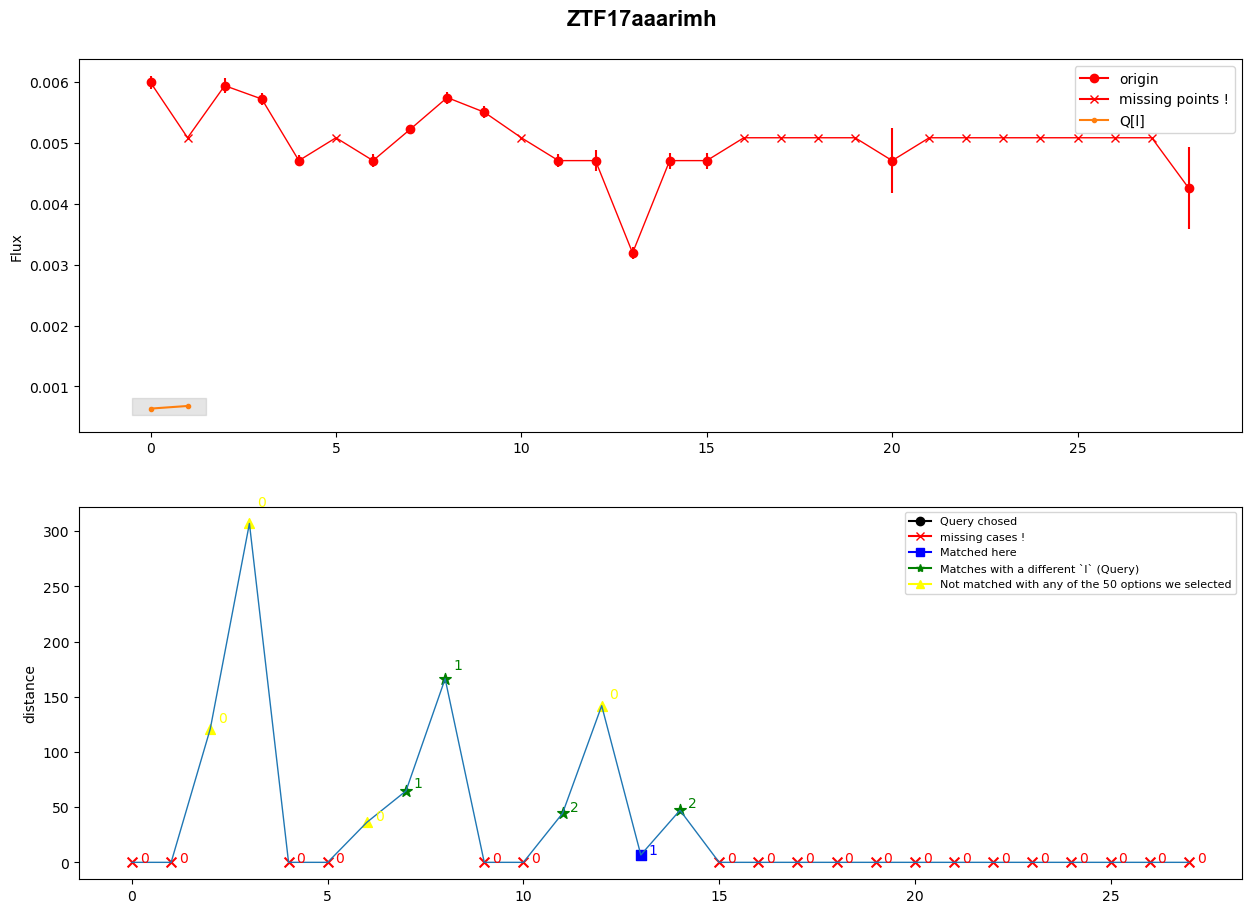

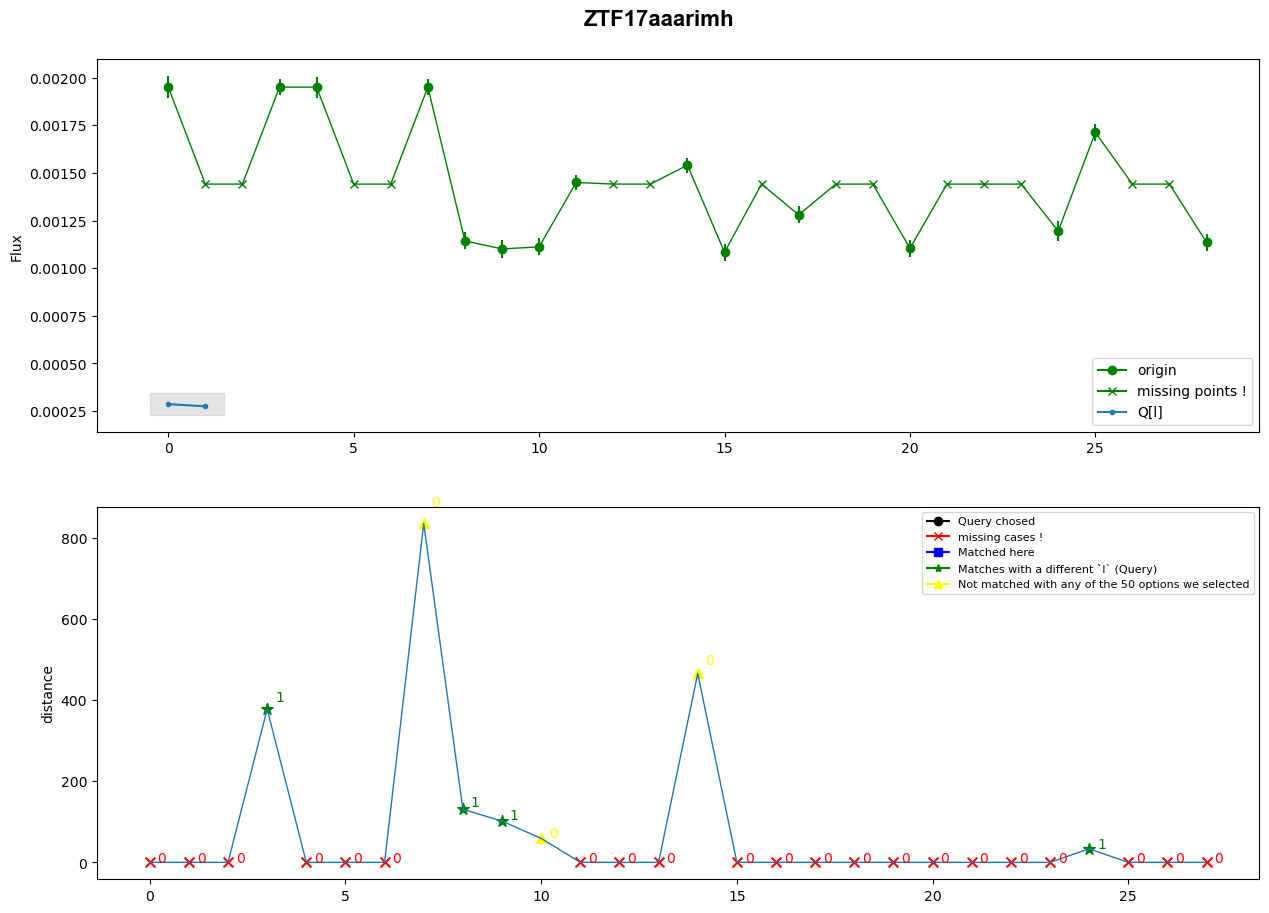

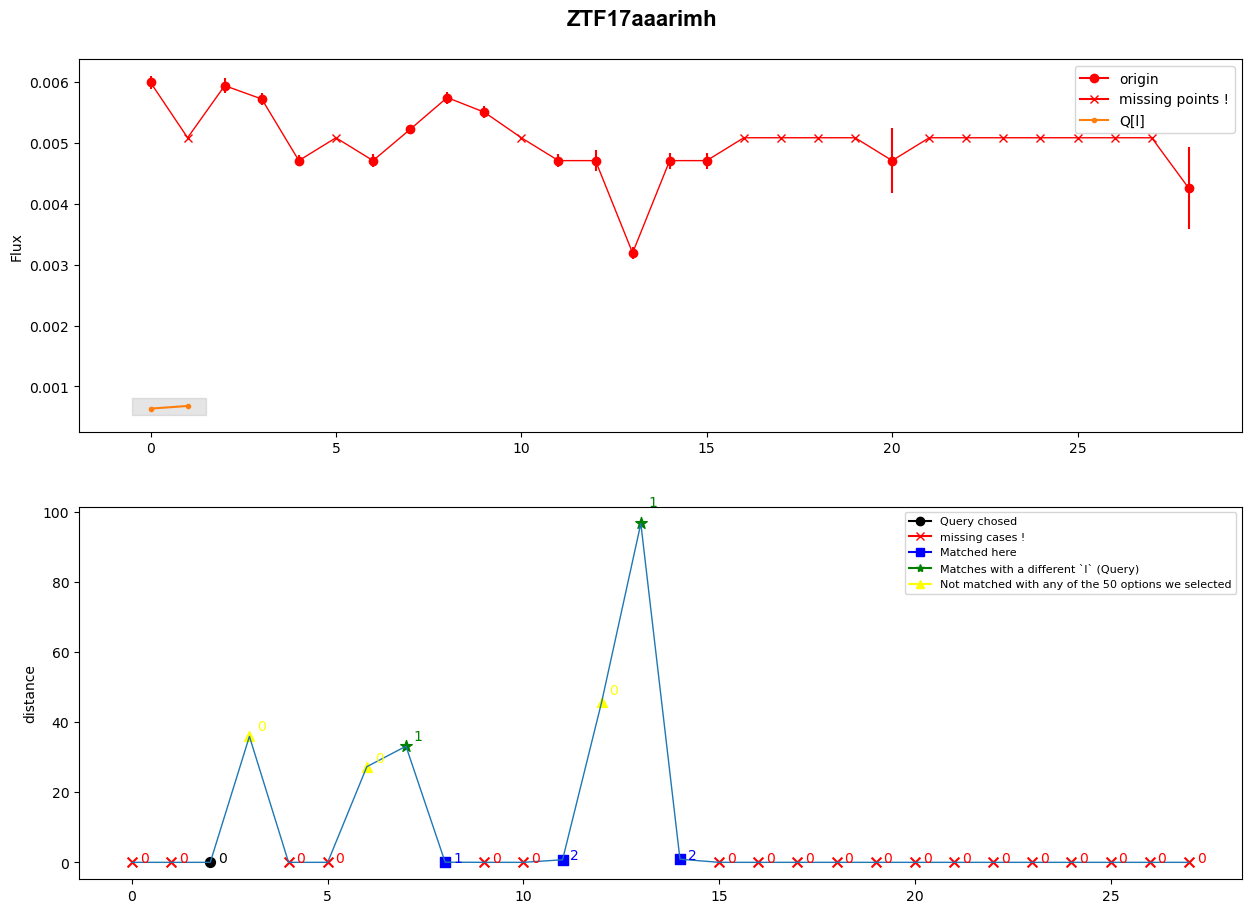

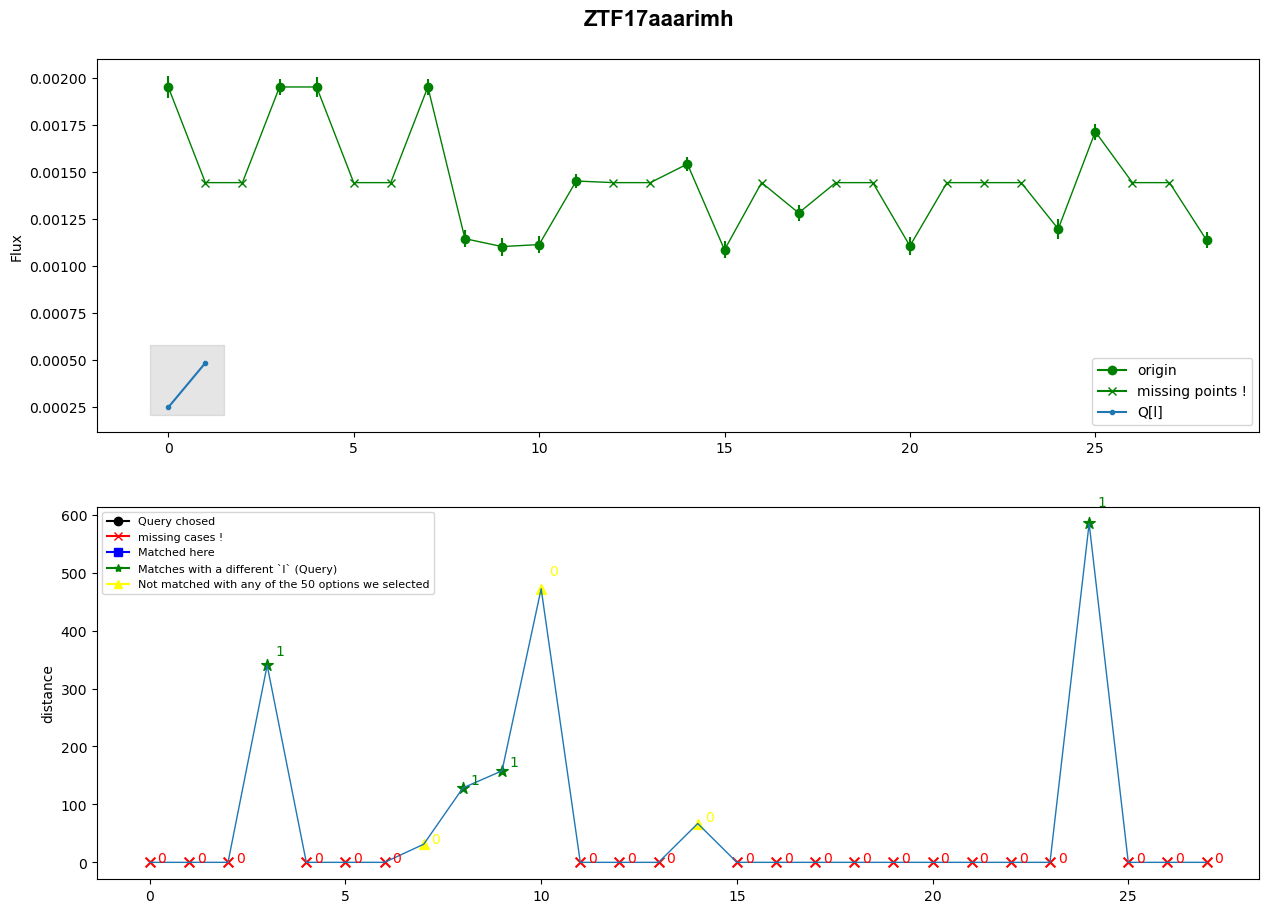

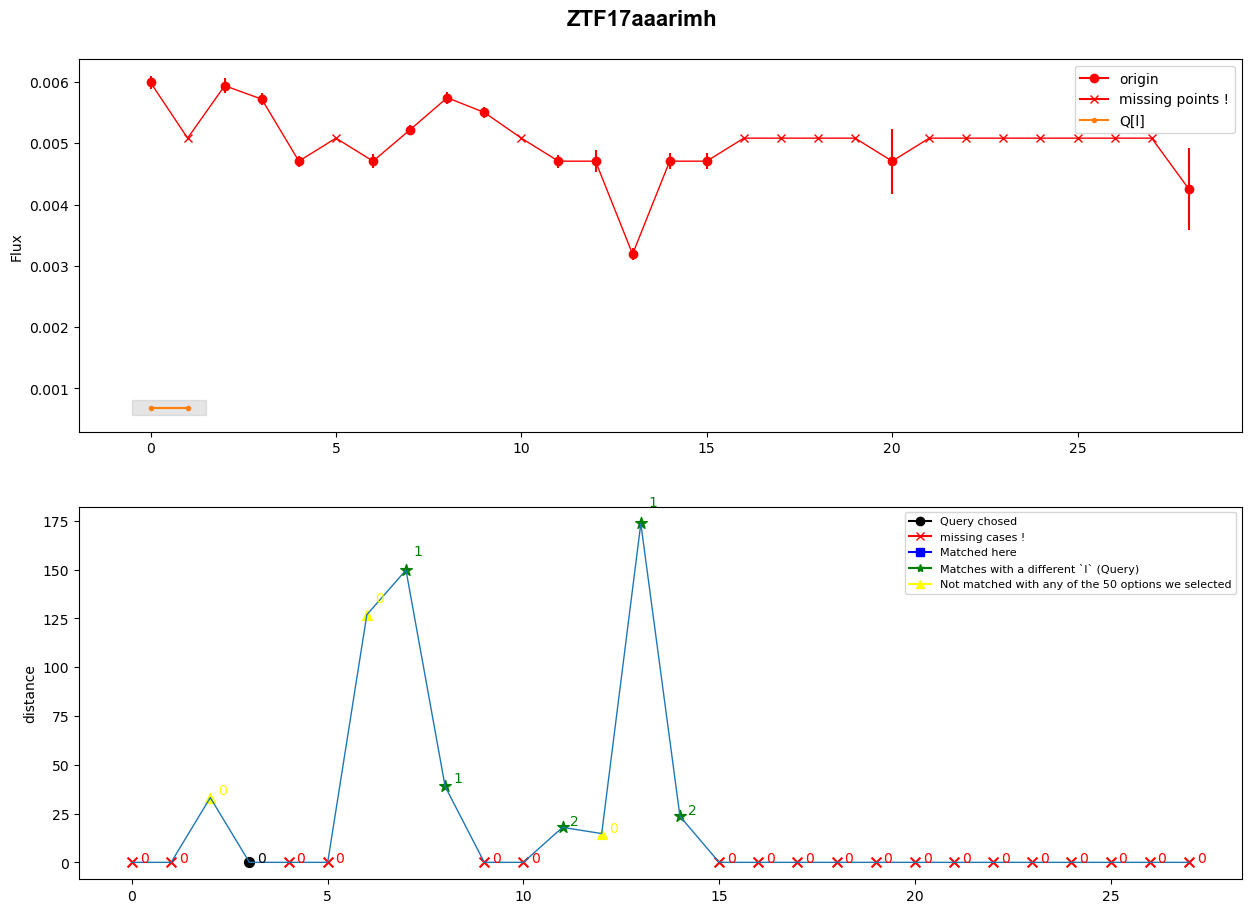

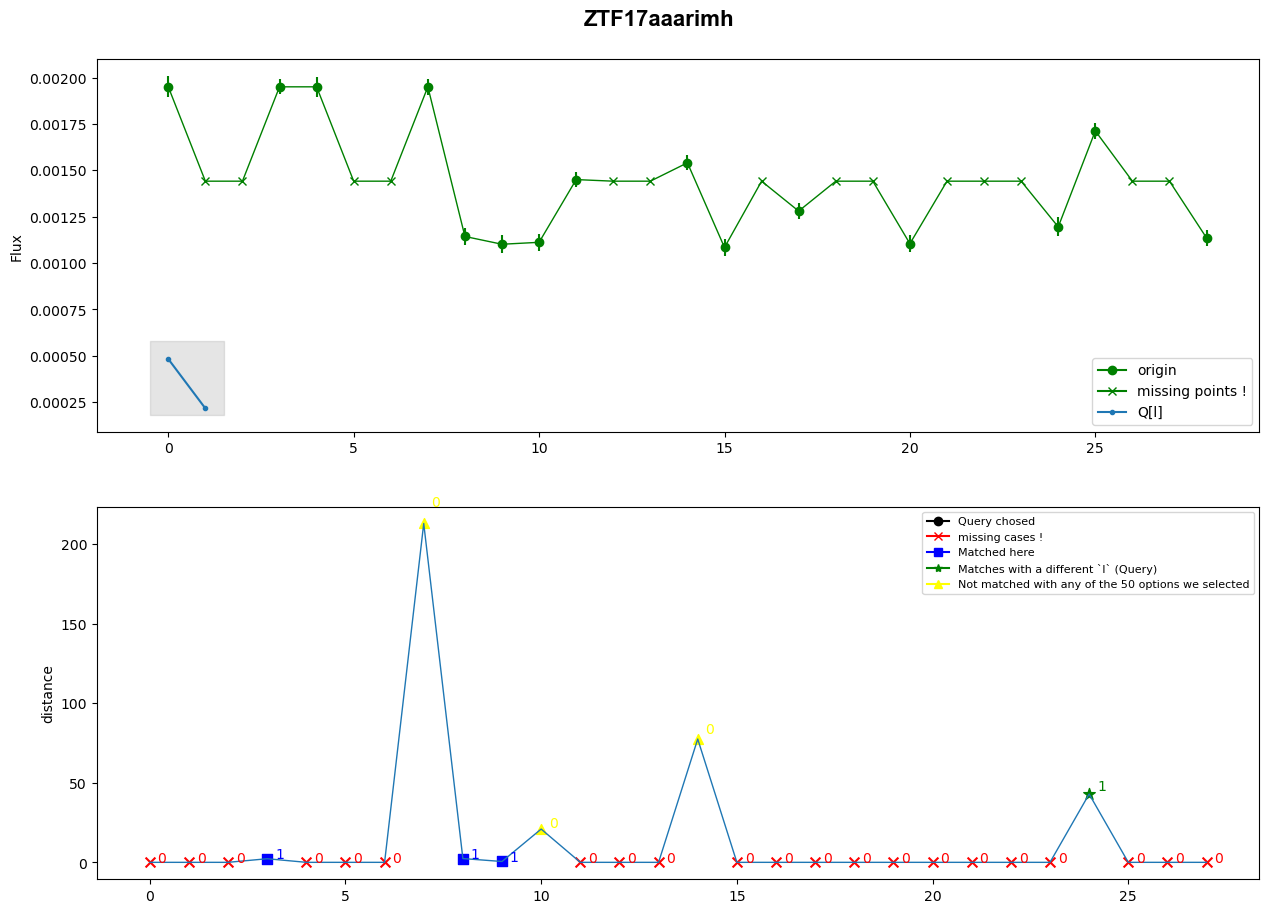

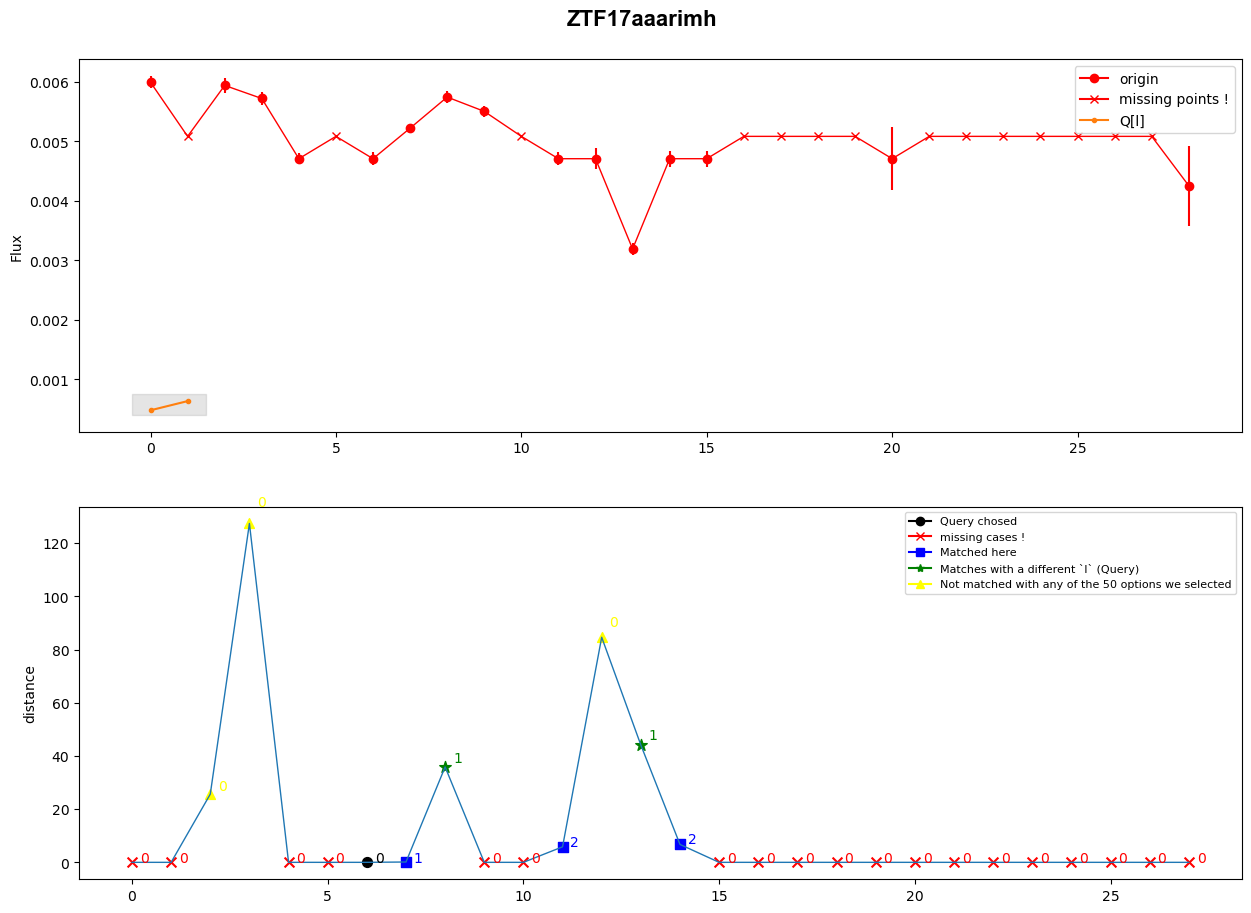

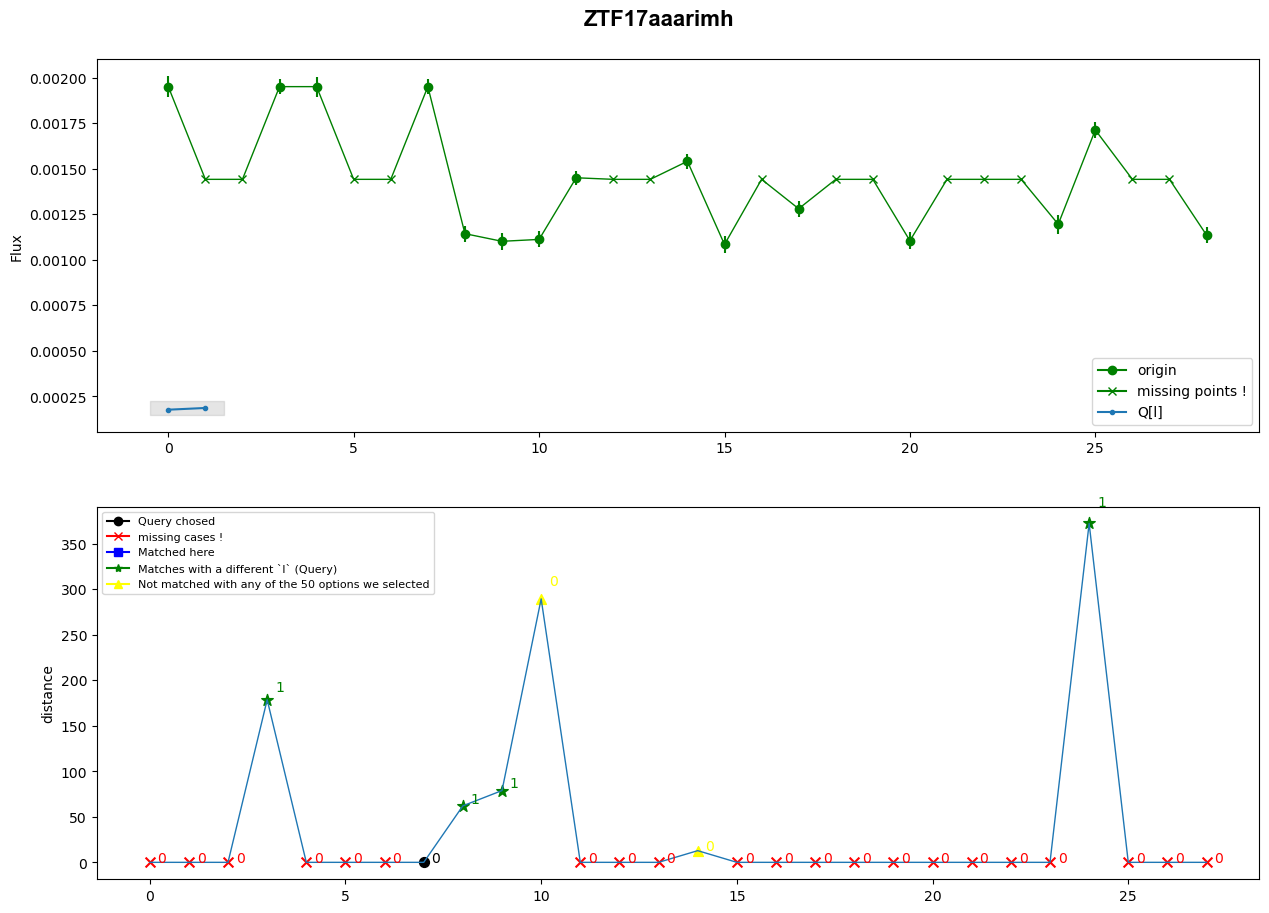

In [88]:
l_values = [4,0,1,2,3]#range(L_max)  # Replace num_values_of_l with the actual number of l values
k=1
for l in l_values:
#     plot_distance_flux_g(k,l)
#    plot_distance_flux_r(k,l)
    plot_distance_flux_r_g(k,l,1,d_r,R_l_r,all_matches_r[k])
    plot_distance_flux_r_g(k,l,0,d_g,R_l_g,all_matches_g[k])
    

In [51]:
import numpy as np

# Given data
f = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
index_no_match = 4
chunk_size = 4

# Initialize Q[l]
Q = np.array([])

# First part
Q = f[index_no_match : index_no_match + chunk_size : 2]
index_no_match = 2
f = np.array([10, 11, 12, 13, 14, 15, 16, 17, 18,19])

# Second part
for i in range(1, chunk_size, 2):
    print(i)
    Q = np.insert(Q, i, f[index_no_match*2 + i : index_no_match*2 + i + 1])

# Print Q[l]
print(Q)
# 15 17 =2
# 13 15 =1

1
3
[ 4 15  6 17]


#

#

#

#

#

#

#

#

#

# TEST

In [ ]:
list1 = [0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9]
list2 = [[0,0,1,1],[1,1,2,2],[2,2,3,3],[3,3,4,4],[4,4,5,5]]

In [ ]:
m=1
idx =3
chunk_size = 2 * (m + 1)
list1[idx*2:idx*2+chunk_size:2]

In [ ]:
m=1
idx =3
chunk_size = 2 * (m + 1)
list1[idx*2:idx*2+chunk_size]

In [ ]:
R = np.empty(len(objects), dtype=object)

m=1
chunk_size =2 * (m + 1)

for k in range(len(objects)):

    n = len(source[k])
    #num_chunks = n // chunk_size

    #chunks = [source[k][i*chunk_size : (i+1)*chunk_size] for i in range(num_chunks)]
    num_chunks = int(n // 2)-m 

    print(n,num_chunks)


    chunks = np.array([source[k][i*2 : (i*2+chunk_size)] for i in range(num_chunks)])
#     if m>0: 
#         for j in range(1, m+1):
#             chunks.extend([source[k][i*chunk_size +j*2 : (i+1)*chunk_size+j*2] for i in range(num_chunks-1)])
#     if m > 0:
#         for j in range(1, m + 1):
#             for i in range(num_chunks - 1):
#                 chunks.append(source[k][i * chunk_size + j * 2: (i + 1) * chunk_size + j * 2])

    #result = np.concatenate(np.array([no_match_test(chunk) for chunk in chunks]))  # Apply no_match_test directly
    result = np.array(list(map(no_match_test, chunks)))
    R[k] = result

    ### le

In [ ]:
m=0
for j in range(1, max(1, m+1)):
    print(j*2)

if m>0: 
    for j in range(1, m+1):
        print(j*2)

In [ ]:
import timeit

m = 100

code_snippet_1 = """
s_1 = np.zeros(n, dtype=float)
s_2 = np.zeros(n, dtype=float)
s_3 = np.zeros(n, dtype=float)
s_4 = np.zeros(n, dtype=float)
s_5 = np.zeros(n, dtype=float)
s_6 = np.zeros(n, dtype=float)
"""

code_snippet_2 = """
zeros = np.zeros(n, dtype=float)

s_1 = zeros.copy()
s_2 = zeros.copy()
s_3 = zeros.copy()
s_4 = zeros.copy()
s_5 = zeros.copy()
s_6 = zeros.copy()

"""

time_taken_1 = timeit.timeit(stmt=code_snippet_1, number=10000000, globals=globals())
time_taken_2 = timeit.timeit(stmt=code_snippet_2, number=10000000, globals=globals())

print("Time snippet 1:", time_taken_1)
print("Time snippet 2:", time_taken_2)



#

#

#

# distance dict to dataframe 

In [ ]:
d

#

#

# Trash

In [61]:
def plot_distance_flux_g(k,l):
    
    # # Plotting
    plt.figure(figsize=(15, 10))

    # Plot for F[k]
    plt.subplot(2, 1, 1)

    # plt.plot(range(int(len(F[k])/2)), F[k][::2], c='g', label='F[k] Even')
    #plt.plot(range(int(len(F[k])/2)), F[k][1::2], c='r', label='F[k] Odd')

    for i in range(int(len(F[objects[k]])/2)):
        if source[objects[k]][2*i] == 0:
            marker = 'x'
            plt.errorbar(i, F[objects[k]][2*i], 
                     #sig[objects[k]][2*i]*0.4,
                     c='g', marker=marker)
        else:
            marker = 'o'
            plt.errorbar(i, F[objects[k]][2*i], 
                         sig[objects[k]][2*i],
                         c='g', marker=marker)

    #     if source[k][2*i+1] == 0:
    #         marker = 'x'
    #     else:
    #         marker = 'o'
    #     plt.errorbar(i, F[k][2*i+1],
    #                  sig[k][2*i+1]*0.4,
    #                  c='r', marker=marker)
    # plt.plot([], [], color='red', marker='x', label='missing points !')
    plt.plot([], [], color='green', marker='o', label='origin')
    plt.plot([], [], color='green', marker='x', label='missing points !')
    # plt.plot([], [], color='red', marker='o', label='origin')


    plt.plot(range(int(len(F[objects[k]])/2)), F[objects[k]][::2], c='g', linewidth = 1)
    # plt.plot(range(int(len(F[k])/2)), F[k][1::2], c='r', linewidth = 1)


    plt.plot(range(int(len(Q[l])/2)), Q[l][::2], c='C0', label='Q[l]',marker='.')
    #plt.plot(range(int(len(Q[0])/2)), Q[l][1::2], c='C1', label='Q[l]',marker='.')

    # Define the window of indices
    window_start = -0  # Index of the window start
    window_end = int(len(Q[l])/2 - 1)  # Index of the window end

    # Create an array of float indices
    indices = np.arange(window_start, window_end + 1)
    indices = np.concatenate(([indices[0] - 0.5], indices, [indices[-1] + 0.5]))

    # Plot a shaded region for the window
    plt.fill_between(indices, min(Q[l][::2])/1.2, max(Q[l][::2])*1.2, color='gray', alpha=0.2)

    # plt.xlabel('Index')
    plt.ylabel('Flux')
    # plt.title('Flux Plot')
    plt.legend()

    # Plot for d[k][0]

    plt.subplot(2, 1, 2)
    plt.plot(range(len(d_g[k][l])), d_g[k][l],color='C0', linestyle='-',linewidth=1)
    matches = all_matches_g[k]
    for i, match_count in enumerate(matches):
        plt.text(i+0.2, d_g[k][l][i]+d_g[k][l][i]*5/100, str(match_count), fontsize=10, color='red', ha='left')


        # Plot dummy points with desired colors and markers
    plt.plot([], [], color='black', marker='o', label='Query chosed')
    plt.plot([], [], color='red', marker='x', label='missing cases !')
    plt.plot([], [], color='blue', marker='s', label='Matched here')
    plt.plot([], [], color='green', marker='*', label='Matches with a different `l` (Query)')
    plt.plot([], [], color='yellow', marker='^', label=f'Not matched with any of the {L_max} options we selected')

    for i, val in enumerate(R_l_g[k][l]):
            if val == -99:
                plt.scatter(i, d_g[k][l][i], color='red', marker='x', s=50)  # marker size 50
            elif val == l:
                plt.scatter(i, d_g[k][l][i], color='blue', marker='s', s=50)
            elif val == -2:
                plt.scatter(i, d_g[k][l][i], color='black', marker='o', s=50)  

            elif matches[i]==0:
                plt.scatter(i, d_g[k][l][i], color='yellow', marker='^', s=50)  
            else:
                plt.scatter(i, d_g[k][l][i], color='green', marker='*', s=75)




    plt.legend(fontsize=8) 

    plt.ylabel('distance')


    # # Plot for alphat[k][0]
    # plt.subplot(4, 1, 4)
    # plt.plot(range(len(alp[k][l][::2])), alp[k][l][::2], marker='.', linestyle='-',color='black')
    # plt.xlabel('Index')
    # plt.ylabel('alpha')
    # # plt.title('alpha Plot')


    plt.subplots_adjust(top=0.93)  # Adjust the top margin for the super title
    plt.suptitle(f"{objects[k]}", fontname='Arial', fontsize=16, fontweight='bold')

    plt.show()



In [62]:
def plot_distance_flux_r(k,l):
    
    # # Plotting
    plt.figure(figsize=(15, 10))

    # Plot for F[k]
    plt.subplot(2, 1, 1)

    # plt.plot(range(int(len(F[k])/2)), F[k][::2], c='g', label='F[k] Even')
    #plt.plot(range(int(len(F[k])/2)), F[k][1::2], c='r', label='F[k] Odd')

    for i in range(int(len(F[objects[k]])/2)):
#         if source[objects[k]][2*i] == 0:
#             marker = 'x'
#             plt.errorbar(i, F[objects[k]][2*i], 
#                      #sig[objects[k]][2*i]*0.4,
#                      c='g', marker=marker)
#         else:
#             marker = 'o'
#             plt.errorbar(i, F[objects[k]][2*i], 
#                          sig[objects[k]][2*i]*0.4,
#                          c='g', marker=marker)

        if source[objects[k]][2*i+1] == 0:
            marker = 'x'
            plt.errorbar(i, F[objects[k]][2*i+1],
                     #sig[objects[k]][2*i+1]*0.4,
                     c='r', marker=marker)
        else:
            marker = 'o'
            plt.errorbar(i, F[objects[k]][2*i+1],
                     sig[objects[k]][2*i+1],
                     c='r', marker=marker)
            
    plt.plot([], [], color='red', marker='x', label='missing points !')
#     plt.plot([], [], color='green', marker='o', label='origin')
#     plt.plot([], [], color='green', marker='x', label='missing points !')
    plt.plot([], [], color='red', marker='o', label='origin')


#     plt.plot(range(int(len(F[objects[k]])/2)), F[objects[k]][::2], c='g', linewidth = 1)
    plt.plot(range(int(len(F[objects[k]])/2)), F[objects[k]][1::2], c='r', linewidth = 1)


#     plt.plot(range(int(len(Q[l])/2)), Q[l][::2], c='C0', label='Q[l]',marker='.')
    plt.plot(range(int(len(Q[l])/2)), Q[l][1::2], c='C1', label='Q[l]',marker='.')

    # Define the window of indices
    window_start = -0  # Index of the window start
    window_end = int(len(Q[l])/2 - 1)  # Index of the window end

    # Create an array of float indices
    indices = np.arange(window_start, window_end + 1)
    indices = np.concatenate(([indices[0] - 0.5], indices, [indices[-1] + 0.5]))

    # Plot a shaded region for the window
    plt.fill_between(indices, min(Q[l][1::2])/1.2, max(Q[l][1::2])*1.2, color='gray', alpha=0.2)

    # plt.xlabel('Index')
    plt.ylabel('Flux')
    # plt.title('Flux Plot')
    plt.legend()

    # Plot for d[k][0]

    plt.subplot(2, 1, 2)
    plt.plot(range(len(d_r[k][l])), d_r[k][l],color='C0', linestyle='-',linewidth=1)
    matches = all_matches_r[k]
#     for i, match_count in enumerate(matches):
#         print(match_count)
        #plt.text(i+0.2, d_r[k][l][i]+d_r[k][l][i]*5/100, str(match_count), fontsize=10, color='red', ha='left')


        # Plot dummy points with desired colors and markers
    plt.plot([], [], color='black', marker='o', label='Query chosed')
    plt.plot([], [], color='red', marker='x', label='missing cases !')
    plt.plot([], [], color='blue', marker='s', label='Matched here')
    plt.plot([], [], color='green', marker='*', label='Matches with a different `l` (Query)')
    plt.plot([], [], color='yellow', marker='^', label=f'Not matched with any of the {L_max} options we selected')

    for i, val in enumerate(R_l_r[k][l]):
            if val == -99:
                plt.scatter(i, d_r[k][l][i], color='red', marker='x', s=50)  # marker size 50
                plt.text(i+0.2, d_r[k][l][i]+d_r[k][l][i]*5/100, str(matches[i]), fontsize=10, color='red', ha='left')

            elif val == l:
                plt.scatter(i, d_r[k][l][i], color='blue', marker='s', s=50)
                plt.text(i+0.2, d_r[k][l][i]+d_r[k][l][i]*5/100, str(matches[i]), fontsize=10, color='blue', ha='left')

            elif val == -2:
                plt.scatter(i, d_r[k][l][i], color='black', marker='o', s=50) 
                plt.text(i+0.2, d_r[k][l][i]+d_r[k][l][i]*5/100, str(matches[i]), fontsize=10, color='black', ha='left')
            elif matches[i]==0:
                plt.scatter(i, d_r[k][l][i], color='yellow', marker='^', s=50) 
                plt.text(i+0.2, d_r[k][l][i]+d_r[k][l][i]*5/100, str(matches[i]), fontsize=10, color='yellow', ha='left')

            else:
                plt.scatter(i, d_r[k][l][i], color='green', marker='*', s=75)
                
                plt.text(i+0.2, d_r[k][l][i]+d_r[k][l][i]*5/100, str(matches[i]), fontsize=10, color='green', ha='left')





    plt.legend(fontsize=8) 

    plt.ylabel('distance')


    # # Plot for alphat[k][0]
    # plt.subplot(4, 1, 4)
    # plt.plot(range(len(alp[k][l][::2])), alp[k][l][::2], marker='.', linestyle='-',color='black')
    # plt.xlabel('Index')
    # plt.ylabel('alpha')
    # # plt.title('alpha Plot')


    plt.subplots_adjust(top=0.93)  # Adjust the top margin for the super title
    plt.suptitle(f"{objects[k]}, k= {k}, l = {l}", fontname='Arial', fontsize=16, fontweight='bold')

    plt.show()

